In [2]:
import nltk
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trinhtrantran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!pip install nltk pandas matplotlib seaborn wordcloud scikit-learn gensim numpy spacy


  Using cached spacy-3.8.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.12-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached cymem-2.0.11-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.5 kB)
  Using cached preshed-3.0.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.2 kB)
  Using cached thinc-8.3.6-cp311-cp311-macosx_11_0_arm64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.15.3-py3-none-any.whl.metadata (15 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached pydantic-2.11.4-py3-none-any.whl.metadata (

In [3]:
class LoadData:
    def __init__(self, en_file_path, es_file_path):
        self.en_file_path = en_file_path
        self.es_file_path = es_file_path
        self.df_en = None
        self.df_es = None

    def load(self):
        # Load English data
        print("Loading English data...")
        self.df_en = pd.read_csv(self.en_file_path)
        print("English data loaded successfully.")
        
        # Load Spanish data
        print("Loading Spanish data...")
        self.df_es = pd.read_csv(self.es_file_path)
        print("Spanish data loaded successfully.")
        
        return self.df_en, self.df_es

# EDA

In [6]:
class EDA:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.en_data = None
        self.es_data = None

    def load_data(self):
        """Load English and Spanish datasets"""
        self.en_data = pd.read_csv(self.data_loader.en_file_path)
        self.es_data = pd.read_csv(self.data_loader.es_file_path)

    def analyze_data(self, language='english'):
        """Perform basic analysis on the dataset"""
        data = self.en_data if language == 'english' else self.es_data

        print(f"\n{'-'*40}")
        print(f"DATA ANALYSIS ({language.upper()})")
        print(f"{'-'*40}")

        # 1. Basic Information
        print("\n[BASIC INFORMATION]")
        print(f"Number of samples: {len(data)}")
        print(f"Columns: {data.columns.tolist()}")
        print("\nFirst 5 rows:")
        print(data.head())

        # 2. Label Distribution
        self._plot_label_distribution(data, language)

        # 3. Text Length Analysis
        self._analyze_text_length(data, language)

        # 4. Word Frequency
        self._plot_word_frequency(data, language, top_n=20)

        # 5. WordCloud
        self._generate_wordcloud(data, language)

        # 6. Missing Values
        print("\n[MISSING VALUES]")
        print(data.isnull().sum())

    def _plot_label_distribution(self, data, language): 
        """Visualize binary label distribution"""
        plt.figure(figsize=(6,5))
        
        # Create countplot
        ax = sns.countplot(x='binary', data=data, palette=['#FF6B6B', '#4ECDC4']) 

        plt.title(f'Binary Label Distribution ({language})')
        
        # Add value labels on top of each bar
        for i in ax.containers:
            ax.bar_label(i, padding=3)
            
        plt.tight_layout()
        plt.show()

    def _analyze_text_length(self, data, language):
        """Analyze text lengths"""
        data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))

        print("\n[TEXT LENGTH STATISTICS]")
        print(data['text_length'].describe())

        plt.figure(figsize=(10,6))
        sns.histplot(data['text_length'], bins=30)
        plt.title(f'Text Length Distribution ({language})')
        plt.xlabel('Number of words')
        plt.show()

    def _plot_word_frequency(self, data, language, top_n=20):
        """Analyze word frequency"""
        words = []
        for text in data['text']:
            words.extend(str(text).lower().split())

        word_freq = Counter(words)
        common_words = word_freq.most_common(top_n)

        plt.figure(figsize=(12,6))
        sns.barplot(x=[count for word, count in common_words], 
                    y=[word for word, count in common_words])
        plt.title(f'Top {top_n} Frequent Words ({language})')
        plt.show()

    def _generate_wordcloud(self, data, language):
        """Generate word cloud"""
        text = " ".join(str(review) for review in data['text'])

        wordcloud = WordCloud(width=800, 
                            height=400,
                            background_color='white',
                            collocations=False).generate(text)

        plt.figure(figsize=(15,8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Word Cloud ({language})')
        plt.show()

    def compare_languages(self):
        """Compare characteristics between English and Spanish"""
        print("\n[LANGUAGE COMPARISON]")

        # Compare average text length
        en_avg_len = self.en_data['text'].apply(lambda x: len(str(x).split())).mean()
        es_avg_len = self.es_data['text'].apply(lambda x: len(str(x).split())).mean()
        print("\nAverage Text Length (in words):")
        print(f"- English: {en_avg_len:.1f}")
        print(f"- Spanish: {es_avg_len:.1f}")

        # Compare binary label distribution
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        sns.countplot(x='binary', data=self.en_data, palette=['#FFA07A', '#20B2AA'])

        plt.title('Binary Label Distribution (English)')

        plt.subplot(1, 2, 2)
        sns.countplot(x='binary', data=self.es_data, palette=['#FFD700', '#6495ED'])

        plt.title('Binary Label Distribution (Spanish)')
        plt.show()



----------------------------------------
DATA ANALYSIS (ENGLISH)
----------------------------------------

[BASIC INFORMATION]
Number of samples: 5233
Columns: ['text', 'binary', 'multiclass']

First 5 rows:
                                                text    binary  \
0  #USER# #USER# #USER# #USER# You expect a man t...  Not Hope   
1  #USER# #USER# #USER# #USER# Tinubu is actually...  Not Hope   
2  it'd be nice if missguided actually had stock ...      Hope   
3  #USER# Anyway love u bubbly i know i can count...      Hope   
4  “you have a lot of people rooting for you whet...  Not Hope   

         multiclass  
0          Not Hope  
1          Not Hope  
2           Sarcasm  
3  Generalized Hope  
4          Not Hope  


/var/folders/xy/f_0951d57tl5wyqr062y27_40000gn/T/ipykernel_12914/1023265076.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='binary', data=data, palette=['#FF6B6B', '#4ECDC4'])


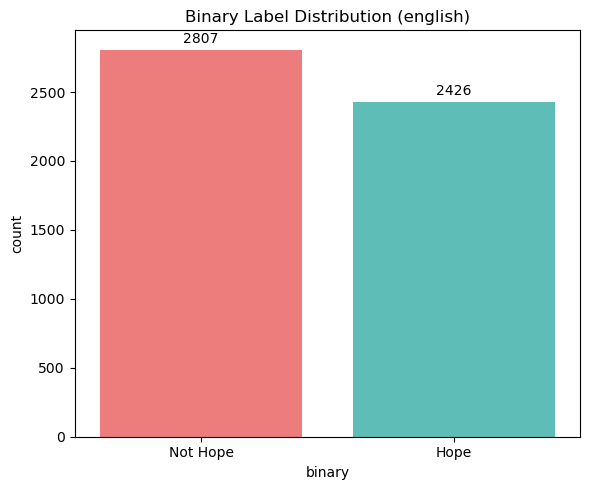


[TEXT LENGTH STATISTICS]
count    5233.000000
mean       33.770304
std        16.436689
min         4.000000
25%        21.000000
50%        31.000000
75%        44.000000
max       144.000000
Name: text_length, dtype: float64


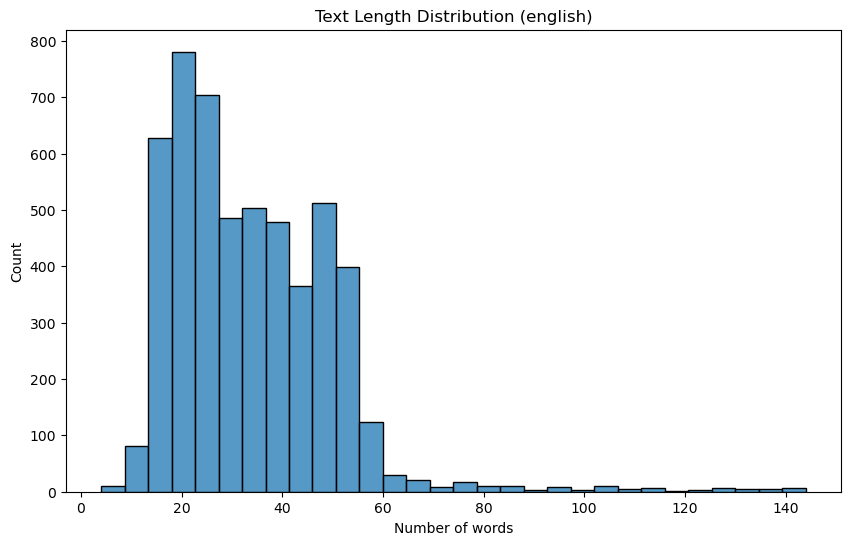

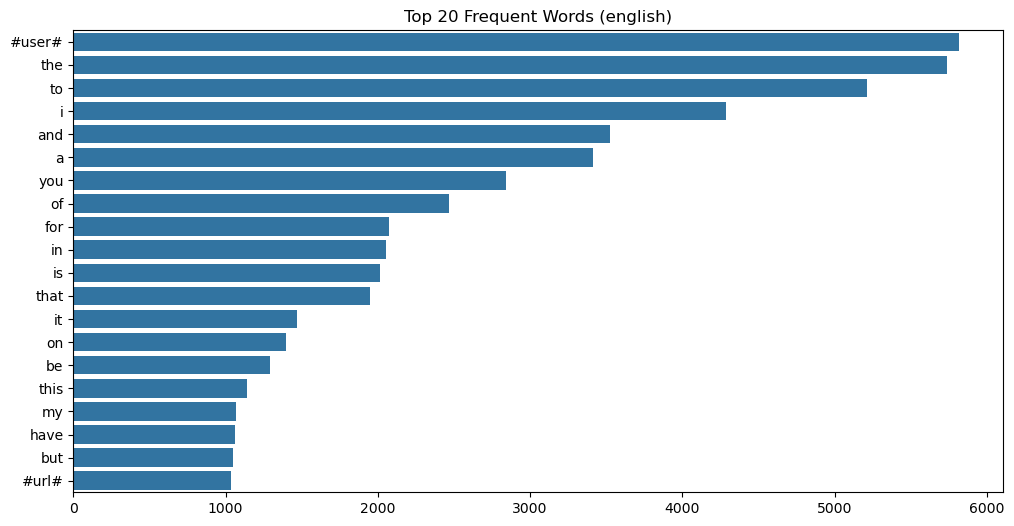

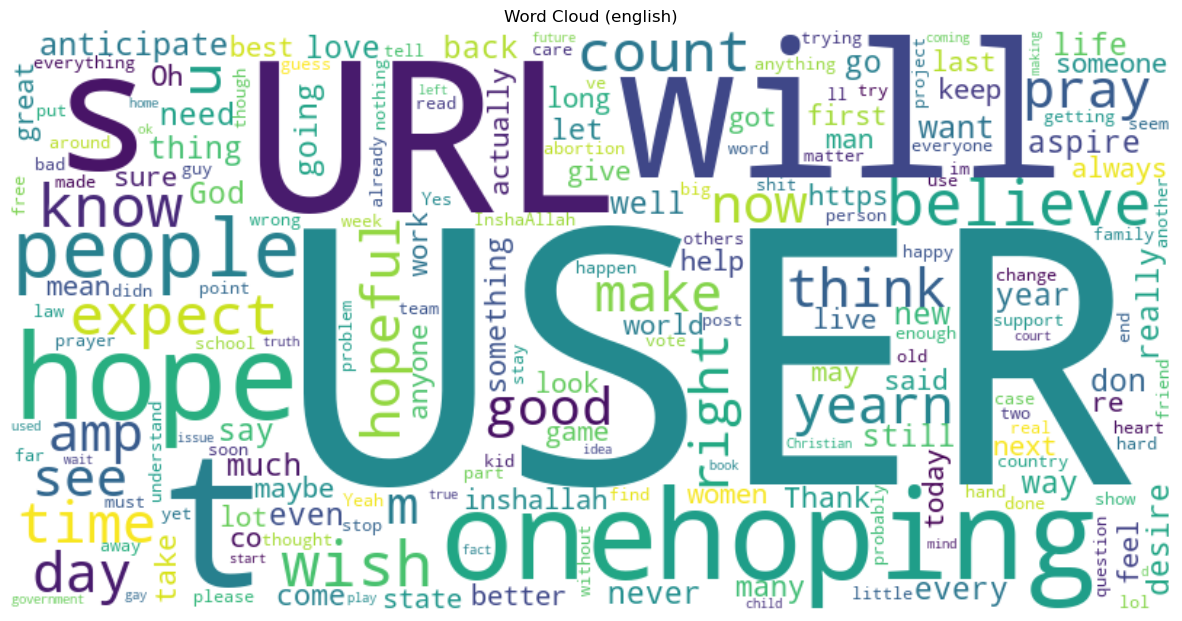


[MISSING VALUES]
text           0
binary         0
multiclass     0
text_length    0
dtype: int64

----------------------------------------
DATA ANALYSIS (SPANISH)
----------------------------------------

[BASIC INFORMATION]
Number of samples: 11243
Columns: ['text', 'binary', 'multiclass']

First 5 rows:
                                                text binary        multiclass
0  🎬Outer Banks🎬 (temporada 3) la verdad que teni...   Hope  Generalized Hope
1  -Después del poco éxito en el grupo de la Jet ...   Hope  Generalized Hope
2  Bárbara López yo te rezo y te hago un monument...   Hope  Generalized Hope
3  RT #USER# #USER# #USER# Ojalá nos ayuden a des...   Hope    Realistic Hope
4  #USER# No tengo las palabras justas. Pero rezo...   Hope    Realistic Hope


/var/folders/xy/f_0951d57tl5wyqr062y27_40000gn/T/ipykernel_12914/1023265076.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='binary', data=data, palette=['#FF6B6B', '#4ECDC4'])


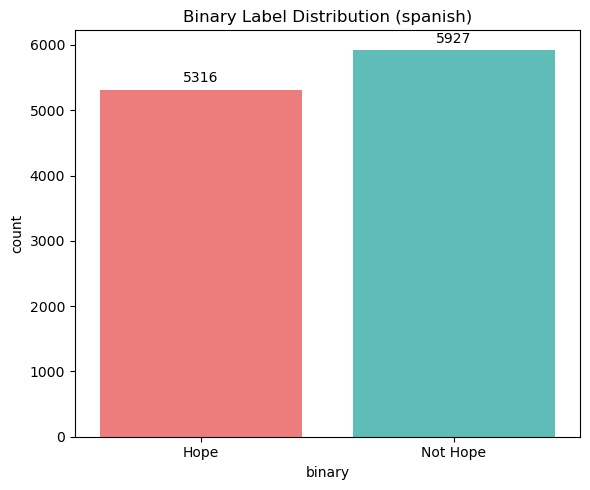


[TEXT LENGTH STATISTICS]
count    11243.000000
mean        26.773904
std         15.846374
min          4.000000
25%         15.000000
50%         22.000000
75%         36.000000
max        172.000000
Name: text_length, dtype: float64


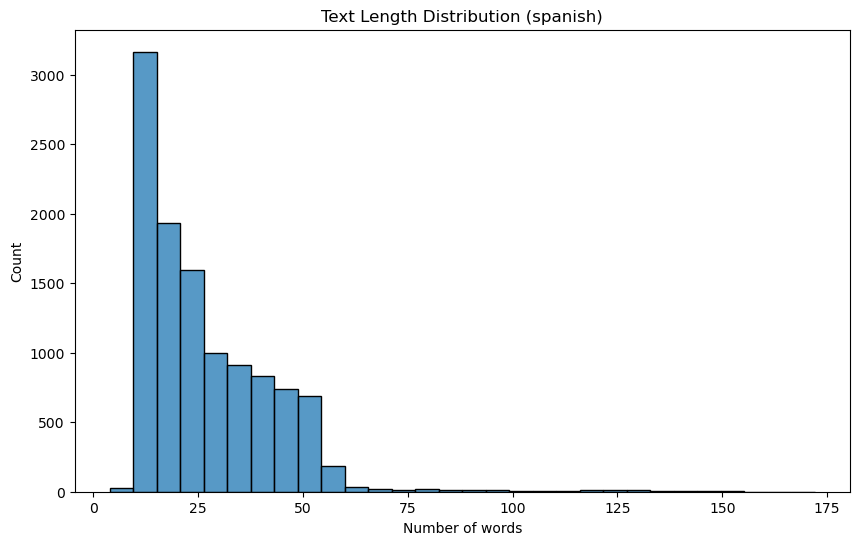

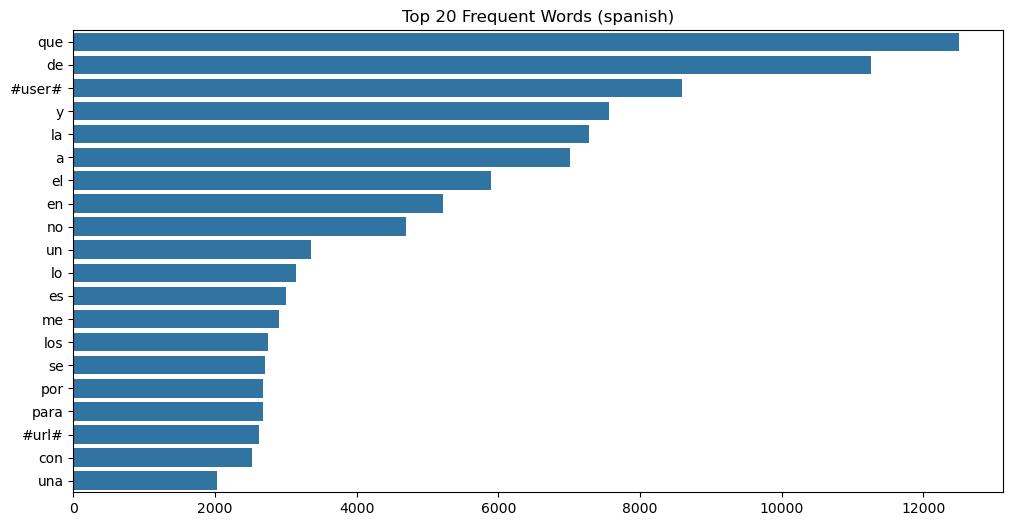

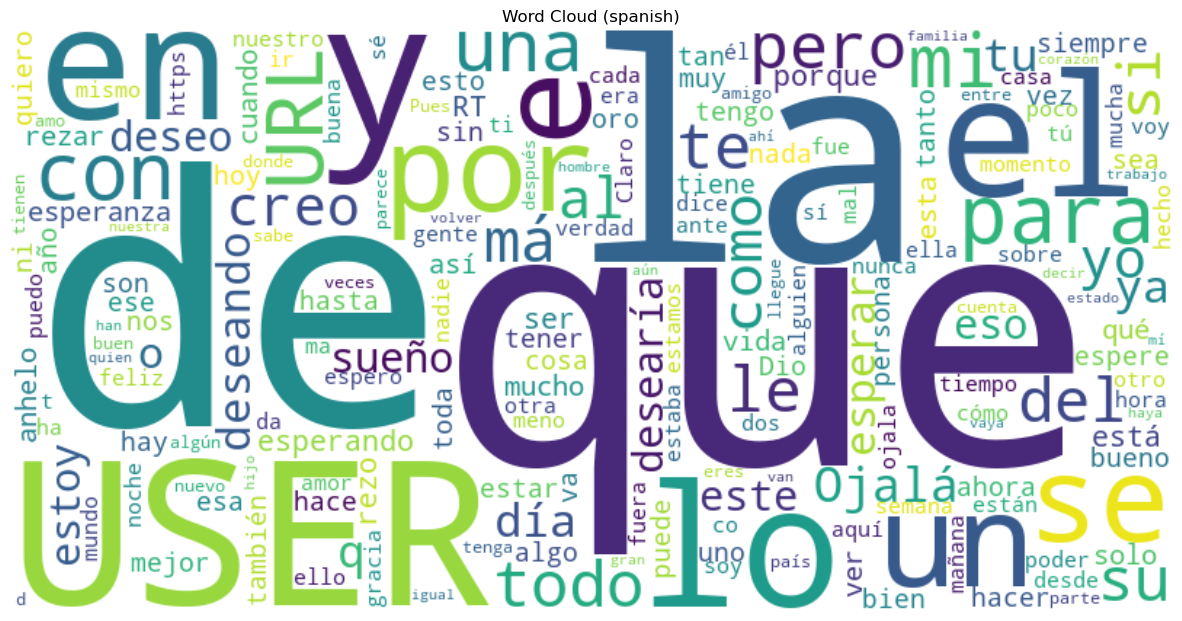


[MISSING VALUES]
text           0
binary         0
multiclass     0
text_length    0
dtype: int64


In [7]:
# Create data loader
data_loader = LoadData(
        en_file_path='../data/en_train.csv',
        es_file_path='../data/es_train.csv'
)

# Create and use EDA
eda = EDA(data_loader)
eda.load_data()
eda.analyze_data(language='english')
eda.analyze_data(language='spanish')

# Preprocessing

In [8]:
class Preprocessing:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.df_en = None
        self.df_es = None
        self.stop_words_en = set(stopwords.words('english'))
        self.stop_words_es = set(stopwords.words('spanish'))
        self.label_encoder_binary = LabelEncoder()
        self.label_encoder_multiclass = LabelEncoder()

    def load_data(self):
        self.df_en, self.df_es = self.data_loader.load()

    def clean_text_en(self, text):
        # Remove URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in self.stop_words_en]
        return ' '.join(filtered_tokens)

    def clean_text_es(self, text):
        # Remove URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in self.stop_words_es]
        return ' '.join(filtered_tokens)

    def preprocess_text_columns(self):
        print("Preprocessing English text...")
        self.df_en['cleaned_text'] = self.df_en['text'].apply(self.clean_text_en)
        
        print("Preprocessing Spanish text...")
        self.df_es['cleaned_text'] = self.df_es['text'].apply(self.clean_text_es)

    def encode_labels(self):
        # Encode English labels
        print("Encoding English labels...")
        self.df_en['binary_encoded'] = self.label_encoder_binary.fit_transform(self.df_en['binary'])
        
        # Encode Spanish labels
        print("Encoding Spanish labels...")
        self.df_es['binary_encoded'] = self.label_encoder_binary.transform(self.df_es['binary'])

    def save_preprocessed_data(self, en_output_path, es_output_path):
        print("Saving preprocessed English data...")
        self.df_en.to_csv(en_output_path, index=False)
        print(f"English data saved to {en_output_path}")
        
        print("Saving preprocessed Spanish data...")
        self.df_es.to_csv(es_output_path, index=False)
        print(f"Spanish data saved to {es_output_path}")

In [123]:
# Create data loader
data_loader = LoadData(
        en_file_path='../data/en_train.csv',
        es_file_path='../data/es_train.csv'
)

# Create and use EDA
preprocessing = Preprocessing(data_loader)
preprocessing.load_data()

# Clean text
preprocessing.preprocess_text_columns()

# Encode labels
preprocessing.encode_labels()

# Save preprocessed data
preprocessing.save_preprocessed_data(
        en_output_path='../data/en_train_preprocessed.csv',
        es_output_path='../data/es_train_preprocessed.csv'
)

Loading English data...
English data loaded successfully.
Loading Spanish data...
Spanish data loaded successfully.
Preprocessing English text...
Preprocessing Spanish text...
Encoding English labels...
Encoding Spanish labels...
Saving preprocessed English data...
English data saved to ../data/en_train_preprocessed.csv
Saving preprocessed Spanish data...
Spanish data saved to ../data/es_train_preprocessed.csv


In [9]:
# Create data loader
data_loader = LoadData(
        en_file_path='../data/en_dev.csv',
        es_file_path='../data/es_dev.csv'
)

# Create and use EDA
preprocessing = Preprocessing(data_loader)
preprocessing.load_data()

# Clean text
preprocessing.preprocess_text_columns()

# Encode labels
preprocessing.encode_labels()

# Save preprocessed data
preprocessing.save_preprocessed_data(
        en_output_path='../data/en_dev_preprocessed.csv',
        es_output_path='../data/es_dev_preprocessed.csv'
)

Loading English data...
English data loaded successfully.
Loading Spanish data...
Spanish data loaded successfully.
Preprocessing English text...
Preprocessing Spanish text...
Encoding English labels...
Encoding Spanish labels...
Saving preprocessed English data...
English data saved to ../data/en_dev_preprocessed.csv
Saving preprocessed Spanish data...
Spanish data saved to ../data/es_dev_preprocessed.csv


# Vectorization

In [ ]:
class Vectorization:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.df_en = None
        self.df_es = None

        # Vectorizers với tham số tối ưu
        self.count_vec_en = CountVectorizer(
            max_features=10000,
            ngram_range=(1,3),
            min_df=1,
            max_df=0.9
        )
        
        self.tfidf_vec_en = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1,3),
            min_df=1,
            max_df=0.9
        )

        self.count_vec_es = CountVectorizer(
            max_features=10000,
            ngram_range=(1,3),
            min_df=1,
            max_df=0.9
        )
        
        self.tfidf_vec_es = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1,3),
            min_df=1,
            max_df=0.9
        )

        self.w2v_model_en = None
        self.w2v_model_es = None
        self.d2v_model_en_dm = None
        self.d2v_model_en_dbow = None
        self.d2v_model_es_dm = None
        self.d2v_model_es_dbow = None

    def load_data(self):
        self.df_en, self.df_es = self.data_loader.load()

    def create_bow_features(self):
        self.bow_features_en = self.count_vec_en.fit_transform(self.df_en['cleaned_text'])
        self.bow_features_es = self.count_vec_es.fit_transform(self.df_es['cleaned_text'])
        return self.bow_features_en, self.bow_features_es

    def create_tfidf_features(self):
        self.tfidf_features_en = self.tfidf_vec_en.fit_transform(self.df_en['cleaned_text'])
        self.tfidf_features_es = self.tfidf_vec_es.fit_transform(self.df_es['cleaned_text'])
        return self.tfidf_features_en, self.tfidf_features_es

    def create_word2vec_features(self, vector_size=300, window=7, min_count=3, sg=1, epochs=30): # use skip gram
        texts_en = [text.split() for text in self.df_en['cleaned_text']]
        texts_es = [text.split() for text in self.df_es['cleaned_text']]

        self.w2v_model_en = Word2Vec(
            sentences=texts_en,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=8,
            sg=sg,
            epochs=epochs
        )
        
        self.w2v_model_es = Word2Vec(
            sentences=texts_es,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=8,
            sg=sg,
            epochs=epochs
        )

        self.w2v_features_en = np.array([
            self.w2v_model_en.wv.get_mean_vector(tokens, pre_normalize=True)
            for tokens in texts_en
        ])
        
        self.w2v_features_es = np.array([
            self.w2v_model_es.wv.get_mean_vector(tokens, pre_normalize=True)
            for tokens in texts_es
        ])
        
        return self.w2v_features_en, self.w2v_features_es

    def _train_doc2vec_model(self, documents, dm, vector_size, window, min_count, epochs):
        model = Doc2Vec(
            documents=documents,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=4,
            epochs=epochs,
            dm=dm
        )
        return model

    def create_doc2vec_features(self, vector_size=300, window=10, min_count=4, epochs=50):
        documents_en = [
            TaggedDocument(words=text.split(), tags=[f'en_{i}'])
            for i, text in enumerate(self.df_en['cleaned_text'])
        ]

        documents_es = [
            TaggedDocument(words=text.split(), tags=[f'es_{i}'])
            for i, text in enumerate(self.df_es['cleaned_text'])
        ]

        print("\nTraining English DM model...")
        self.d2v_model_en_dm = self._train_doc2vec_model(
            documents_en, dm=1, 
            vector_size=vector_size, window=window,
            min_count=min_count, epochs=epochs
        )

        print("\nTraining English DBOW model...")
        self.d2v_model_en_dbow = self._train_doc2vec_model(
            documents_en, dm=0,
            vector_size=vector_size, window=window,
            min_count=min_count, epochs=epochs
        )

        print("\nTraining Spanish DM model...")
        self.d2v_model_es_dm = self._train_doc2vec_model(
            documents_es, dm=1,
            vector_size=vector_size, window=window,
            min_count=min_count, epochs=epochs
        )

        print("\nTraining Spanish DBOW model...")
        self.d2v_model_es_dbow = self._train_doc2vec_model(
            documents_es, dm=0,
            vector_size=vector_size, window=window,
            min_count=min_count, epochs=epochs
        )

        self.d2v_features_en = np.array([
            0.8 * self.d2v_model_en_dm.dv[f'en_{i}'] + 0.2 * self.d2v_model_en_dbow.dv[f'en_{i}']
            for i in range(len(self.df_en))
        ])

        self.d2v_features_es = np.array([
            0.8 * self.d2v_model_es_dm.dv[f'es_{i}'] + 0.2 * self.d2v_model_es_dbow.dv[f'es_{i}']
            for i in range(len(self.df_es))
        ])

        return self.d2v_features_en, self.d2v_features_es

    def transform_new_text(self, texts, method='doc2vec', language='english'):
        if method == 'doc2vec':
            dm_model = self.d2v_model_en_dm if language == 'english' else self.d2v_model_es_dm
            dbow_model = self.d2v_model_en_dbow if language == 'english' else self.d2v_model_es_dbow

            vectors = []
            for text in texts:
                tokens = text.split()
                vec_dm = dm_model.infer_vector(tokens, epochs=200, alpha=0.025, min_alpha=0.001)
                vec_dbow = dbow_model.infer_vector(tokens, epochs=200, alpha=0.025, min_alpha=0.001)
                vectors.append(0.4 * vec_dm + 0.6 * vec_dbow)

            return np.array(vectors)

        elif method == 'bow':
            vectorizer = self.count_vec_en if language == 'english' else self.count_vec_es
            return vectorizer.transform(texts)

        elif method == 'tfidf':
            vectorizer = self.tfidf_vec_en if language == 'english' else self.tfidf_vec_es
            return vectorizer.transform(texts)

        elif method == 'word2vec':
            model = self.w2v_model_en if language == 'english' else self.w2v_model_es
            return np.array([
                model.wv.get_mean_vector(text.split(), pre_normalize=True)
                for text in texts
            ])


In [55]:
# Load training data
train_loader = LoadData(
    en_file_path='../data/en_train_preprocessed.csv',
    es_file_path='../data/es_train_preprocessed.csv'
)
train_vectorizer = Vectorization(train_loader)
train_vectorizer.load_data()

# Fit vectorizers on training data
bow_train_en, bow_train_es = train_vectorizer.create_bow_features()
tfidf_train_en, tfidf_train_es = train_vectorizer.create_tfidf_features()
w2v_train_en, w2v_train_es = train_vectorizer.create_word2vec_features()
d2v_train_en, d2v_train_es = train_vectorizer.create_doc2vec_features()

# Extract labels
y_train_en = train_vectorizer.df_en['binary_encoded'].tolist()
y_train_es = train_vectorizer.df_es['binary_encoded'].tolist()

# Print shapes
print("\n--------------- English Train Data ---------------")
print(f"BOW shape:      {bow_train_en.shape}")
print(f"TF-IDF shape:   {tfidf_train_en.shape}")
print(f"Word2Vec shape: {w2v_train_en.shape}")
print(f"Doc2Vec shape: {d2v_train_en.shape}")

print("\n--------------- Spanish Train Data ---------------")
print(f"BOW shape:      {bow_train_es.shape}")
print(f"TF-IDF shape:   {tfidf_train_es.shape}")
print(f"Word2Vec shape: {w2v_train_es.shape}")
print(f"Doc2Vec shape: {d2v_train_es.shape}")


Loading English data...
English data loaded successfully.
Loading Spanish data...
Spanish data loaded successfully.

Training English DM model...

Training English DBOW model...

Training Spanish DM model...

Training Spanish DBOW model...

--------------- English Train Data ---------------
BOW shape:      (5233, 10000)
TF-IDF shape:   (5233, 10000)
Word2Vec shape: (5233, 300)
Doc2Vec shape: (5233, 300)

--------------- Spanish Train Data ---------------
BOW shape:      (11243, 10000)
TF-IDF shape:   (11243, 10000)
Word2Vec shape: (11243, 300)
Doc2Vec shape: (11243, 300)


In [56]:
# Load test data
test_loader = LoadData(
    en_file_path='../data/en_dev_preprocessed.csv',
    es_file_path='../data/es_dev_preprocessed.csv'
)
test_vectorizer = Vectorization(test_loader)
test_vectorizer.load_data()

bow_test_en = train_vectorizer.count_vec_en.transform(test_vectorizer.df_en['cleaned_text'])
bow_test_es = train_vectorizer.count_vec_es.transform(test_vectorizer.df_es['cleaned_text'])

tfidf_test_en = train_vectorizer.tfidf_vec_en.transform(test_vectorizer.df_en['cleaned_text'])
tfidf_test_es = train_vectorizer.tfidf_vec_es.transform(test_vectorizer.df_es['cleaned_text'])

w2v_test_en = train_vectorizer.transform_new_text(test_vectorizer.df_en['cleaned_text'], method='word2vec', language='english')
w2v_test_es = train_vectorizer.transform_new_text(test_vectorizer.df_es['cleaned_text'], method='word2vec', language='spanish')

d2v_test_en = train_vectorizer.transform_new_text(test_vectorizer.df_en['cleaned_text'], method='doc2vec', language='english')
d2v_test_es = train_vectorizer.transform_new_text(test_vectorizer.df_es['cleaned_text'], method='doc2vec', language='spanish')

# Extract labels
y_test_en = test_vectorizer.df_en['binary_encoded'].tolist()
y_test_es = test_vectorizer.df_es['binary_encoded'].tolist()

# Print shapes
print("\n--------------- English Test Data ---------------")
print(f"BOW shape:      {bow_test_en.shape}")
print(f"TF-IDF shape:   {tfidf_test_en.shape}")
print(f"Word2Vec shape: {w2v_test_en.shape}")
print(f"Doc2Vec shape: {d2v_test_en.shape}")

print("\n--------------- Spanish Test Data ---------------")
print(f"BOW shape:      {bow_test_es.shape}")
print(f"TF-IDF shape:   {tfidf_test_es.shape}")
print(f"Word2Vec shape: {w2v_test_es.shape}")
print(f"Doc2Vec shape: {d2v_test_es.shape}")


Loading English data...
English data loaded successfully.
Loading Spanish data...
Spanish data loaded successfully.

--------------- English Test Data ---------------
BOW shape:      (1902, 10000)
TF-IDF shape:   (1902, 10000)
Word2Vec shape: (1902, 300)
Doc2Vec shape: (1902, 300)

--------------- Spanish Test Data ---------------
BOW shape:      (4088, 10000)
TF-IDF shape:   (4088, 10000)
Word2Vec shape: (4088, 300)
Doc2Vec shape: (4088, 300)


# Model

## SVM

### SVM with linear kernel

In [57]:
class SVMClassifier:
    def __init__(self, kernel='linear', C=1.0):
        self.svm_en = SVC(kernel=kernel, C=C)
        self.svm_es = SVC(kernel=kernel, C=C)

    def train(self, X_train, y_train, language='english'):
        if language == 'english':
            print(f"Training English data shape: X={X_train.shape}")
            self.svm_en.fit(X_train, y_train)
        else:
            print(f"Training Spanishs data shape: X={X_train.shape}")
            self.svm_es.fit(X_train, y_train)

    def predict(self, X_test, language='english'):
        return self.svm_en.predict(X_test) if language == 'english' else self.svm_es.predict(X_test)

    def evaluate(self, X_test, y_test, language='english'):
        y_pred = self.predict(X_test, language)
        print(f"\nResults for {language.capitalize()} model:")
        print(f"Test data shape: X={X_test.shape}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [58]:
print("\n========== BOW-SVM ========= ")
bow_svm = SVMClassifier()
bow_svm.train(bow_train_en, y_train_en, 'english')
bow_svm.train(bow_train_es, y_train_es, 'spanish')
bow_svm.evaluate(bow_test_en, y_test_en, 'english')
bow_svm.evaluate(bow_test_es, y_test_es, 'spanish')

print("\n=========  TF-IDF-SVM ========= ")
tfidf_svm = SVMClassifier()
tfidf_svm.train(tfidf_train_en, y_train_en, 'english')
tfidf_svm.train(tfidf_train_es, y_train_es, 'spanish')
tfidf_svm.evaluate(tfidf_test_en, y_test_en, 'english')
tfidf_svm.evaluate(tfidf_test_es, y_test_es, 'spanish')

print("\n=========  Word2Vec-SVM ========= ")
w2v_svm = SVMClassifier()
w2v_svm.train(w2v_train_en, y_train_en, 'english')
w2v_svm.train(w2v_train_es, y_train_es, 'spanish')
w2v_svm.evaluate(w2v_test_en, y_test_en, 'english')
w2v_svm.evaluate(w2v_test_es, y_test_es, 'spanish')

print("\n=========  Doc2Vec-SVM ========= ")
d2v_svm = SVMClassifier()
d2v_svm.train(d2v_train_en, y_train_en, 'english')
d2v_svm.train(d2v_train_es, y_train_es, 'spanish')
d2v_svm.evaluate(d2v_test_en, y_test_en, 'english')
d2v_svm.evaluate(d2v_test_es, y_test_es, 'spanish')


========== BOW-SVM ========= 
Training English data shape: X=(5233, 10000)
Training Spanishs data shape: X=(11243, 10000)

Results for English model:
Test data shape: X=(1902, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.71       899
           1       0.73      0.76      0.75      1003

    accuracy                           0.73      1902
   macro avg       0.73      0.73      0.73      1902
weighted avg       0.73      0.73      0.73      1902

Accuracy: 0.7277

Results for Spanish model:
Test data shape: X=(4088, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1926
           1       0.75      0.73      0.74      2162

    accuracy                           0.73      4088
   macro avg       0.73      0.73      0.73      4088
weighted avg       0.73      0.73      0.73      4088

Accuracy: 0.7319

=========  TF-IDF-SV

### SVM with RBF kernel

In [59]:
class SVMClassifier:
    def __init__(self):
        self.svm_en = None
        self.svm_es = None
        self.best_params_en = None
        self.best_params_es = None

    def train(self, X_train, y_train, language='english'):
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.01, 0.1, 1]
        }
        grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

        print(f"\nTraining {language.capitalize()} model...")
        print(f"Data shape: X={X_train.shape}, y={len(y_train)}")
        grid.fit(X_train, y_train)

        if language == 'english':
            self.svm_en = grid.best_estimator_
            self.best_params_en = grid.best_params_
        else:
            self.svm_es = grid.best_estimator_
            self.best_params_es = grid.best_params_

        print(f"Best parameters for {language.capitalize()}: {grid.best_params_}")

    def predict(self, X_test, language='english'):
        model = self.svm_en if language == 'english' else self.svm_es
        return model.predict(X_test)

    def evaluate(self, X_test, y_test, language='english'):
        y_pred = self.predict(X_test, language)
        print(f"\nResults for {language.capitalize()} model:")
        print(f"Test data shape: X={X_test.shape}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [60]:
print("\n========== BOW-SVM ========= ")
bow_svm = SVMClassifier()
bow_svm.train(bow_train_en, y_train_en, 'english')
bow_svm.train(bow_train_es, y_train_es, 'spanish')
bow_svm.evaluate(bow_test_en, y_test_en, 'english')
bow_svm.evaluate(bow_test_es, y_test_es, 'spanish')

print("\n=========  TF-IDF-SVM ========= ")
tfidf_svm = SVMClassifier()
tfidf_svm.train(tfidf_train_en, y_train_en, 'english')
tfidf_svm.train(tfidf_train_es, y_train_es, 'spanish')
tfidf_svm.evaluate(tfidf_test_en, y_test_en, 'english')
tfidf_svm.evaluate(tfidf_test_es, y_test_es, 'spanish')

print("\n=========  Word2Vec-SVM ========= ")
w2v_svm = SVMClassifier()
w2v_svm.train(w2v_train_en, y_train_en, 'english')
w2v_svm.train(w2v_train_es, y_train_es, 'spanish')
w2v_svm.evaluate(w2v_test_en, y_test_en, 'english')
w2v_svm.evaluate(w2v_test_es, y_test_es, 'spanish')

print("\n=========  Doc2Vec-SVM ========= ")
d2v_svm = SVMClassifier()
d2v_svm.train(d2v_train_en, y_train_en, 'english')
d2v_svm.train(d2v_train_es, y_train_es, 'spanish')
d2v_svm.evaluate(d2v_test_en, y_test_en, 'english')
d2v_svm.evaluate(d2v_test_es, y_test_es, 'spanish')



========== BOW-SVM ========= 

Training English model...
Data shape: X=(5233, 10000), y=5233
Best parameters for English: {'C': 1, 'gamma': 'scale'}

Training Spanish model...
Data shape: X=(11243, 10000), y=11243
Best parameters for Spanish: {'C': 1, 'gamma': 'scale'}

Results for English model:
Test data shape: X=(1902, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       899
           1       0.76      0.85      0.80      1003

    accuracy                           0.78      1902
   macro avg       0.79      0.78      0.78      1902
weighted avg       0.79      0.78      0.78      1902

Accuracy: 0.7829

Results for Spanish model:
Test data shape: X=(4088, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1926
           1       0.77      0.81      0.79      2162

    accuracy                           0.77      4088

## NAIVE BAYES

In [61]:
from scipy import sparse
class NaiveBayesClassifier:
    def __init__(self):
        # For BoW features (always non-negative)
        self.nb_bow_en = MultinomialNB()
        self.nb_bow_es = MultinomialNB()
        
        # For TF-IDF, Word2Vec, and Doc2Vec features (can have negative values)
        self.nb_dense_en = make_pipeline(StandardScaler(), GaussianNB())
        self.nb_dense_es = make_pipeline(StandardScaler(), GaussianNB())

    def train(self, X_train, y_train, language='english', method='bow', grid_search=False):
        if method == 'bow':
            # Use MultinomialNB for BoW
            if grid_search:
                param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}
                grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
            else:
                best_model = MultinomialNB()
                best_model.fit(X_train, y_train)

            if language == 'english':
                self.nb_bow_en = best_model
            else:
                self.nb_bow_es = best_model
        else:
            # Use GaussianNB with StandardScaler for other methods
            model = self.nb_dense_en if language == 'english' else self.nb_dense_es
            
            # Convert sparse matrix to dense if needed
            if sparse.issparse(X_train):
                X_train = X_train.toarray()
                
            model.fit(X_train, y_train)

    def predict(self, X_test, language='english', method='bow'):
        if method == 'bow':
            model = self.nb_bow_en if language == 'english' else self.nb_bow_es
        else:
            model = self.nb_dense_en if language == 'english' else self.nb_dense_es
            if sparse.issparse(X_test):
                X_test = X_test.toarray()
        
        return model.predict(X_test)

    def evaluate(self, X_test, y_test, language='english', method='bow'):
        y_pred = self.predict(X_test, language, method)
        acc = accuracy_score(y_test, y_pred)
        print(f"\nResults for {language.capitalize()} model ({method.upper()}):")
        print(f"Test data shape: X={X_test.shape}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {acc:.4f}")
        return acc

    @staticmethod
    def cross_validate_nb(X, y, method='bow', language='english', cv=5):
        if method == 'bow':
            model = MultinomialNB()
        else:
            model = make_pipeline(StandardScaler(), GaussianNB())
            if sparse.issparse(X):
                X = X.toarray()

        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_validate(model, X, y, cv=kfold, scoring='accuracy')
        acc = np.mean(scores['test_score'])

        print(f"\nCross-validation Accuracy for {language.capitalize()} ({method.upper()}): {acc:.4f}")
        return acc

In [62]:
print("\n========== BOW - Naive Bayes ========= ")
bow_bayes = NaiveBayesClassifier()
bow_bayes.train(bow_train_en, y_train_en, 'english', 'bow', grid_search=True)
bow_bayes.train(bow_train_es, y_train_es, 'spanish', 'bow', grid_search=True)
bow_bayes.evaluate(bow_test_en, y_test_en, 'english', 'bow')
bow_bayes.evaluate(bow_test_es, y_test_es, 'spanish', 'bow')
bow_bayes.cross_validate_nb(bow_train_en, y_train_en, method='bow', language='english')
bow_bayes.cross_validate_nb(bow_train_es, y_train_es, method='bow', language='spanish')

print("\n========= TF-IDF - Naive Bayes ========= ")
tfidf_bayes = NaiveBayesClassifier()
tfidf_bayes.train(tfidf_train_en, y_train_en, 'english', 'tfidf', grid_search=True)
tfidf_bayes.train(tfidf_train_es, y_train_es, 'spanish', 'tfidf', grid_search=True)
tfidf_bayes.evaluate(tfidf_test_en, y_test_en, 'english', 'tfidf')
tfidf_bayes.evaluate(tfidf_test_es, y_test_es, 'spanish', 'tfidf')
bow_bayes.cross_validate_nb(tfidf_train_en, y_train_en, method='tfidf', language='english')
bow_bayes.cross_validate_nb(tfidf_train_es, y_train_es, method='tfidf', language='spanish')

print("\n========= Word2Vec - Naive Bayes ========= ")
w2v_bayes = NaiveBayesClassifier()
w2v_bayes.train(w2v_train_en, y_train_en, 'english', 'word2vec')
w2v_bayes.train(w2v_train_es, y_train_es, 'spanish', 'word2vec')
w2v_bayes.evaluate(w2v_test_en, y_test_en, 'english', 'word2vec')
w2v_bayes.evaluate(w2v_test_es, y_test_es, 'spanish', 'word2vec')
bow_bayes.cross_validate_nb(w2v_train_en, y_train_en, method='word2vec', language='english')
bow_bayes.cross_validate_nb(w2v_train_es, y_train_es, method='word2vec', language='spanish')

print("\n========= Doc2Vec - Naive Bayes ========= ")
w2v_bayes = NaiveBayesClassifier()
w2v_bayes.train(d2v_train_en, y_train_en, 'english', 'doc2vec')  # Thay w2v_train_en → d2v_train_en
w2v_bayes.train(d2v_train_es, y_train_es, 'spanish', 'doc2vec')  # Thay w2v_train_es → d2v_train_es
w2v_bayes.evaluate(d2v_test_en, y_test_en, 'english', 'doc2vec')
w2v_bayes.evaluate(d2v_test_es, y_test_es, 'spanish', 'doc2vec')
bow_bayes.cross_validate_nb(d2v_train_en, y_train_en, method='doc2vec', language='english')
bow_bayes.cross_validate_nb(d2v_train_es, y_train_es, method='doc2vec', language='spanish')




========== BOW - Naive Bayes ========= 

Results for English model (BOW):
Test data shape: X=(1902, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       899
           1       0.76      0.77      0.77      1003

    accuracy                           0.75      1902
   macro avg       0.75      0.75      0.75      1902
weighted avg       0.75      0.75      0.75      1902

Accuracy: 0.7545

Results for Spanish model (BOW):
Test data shape: X=(4088, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1926
           1       0.77      0.77      0.77      2162

    accuracy                           0.76      4088
   macro avg       0.76      0.76      0.76      4088
weighted avg       0.76      0.76      0.76      4088

Accuracy: 0.7568

Cross-validation Accuracy for English (BOW): 0.7562

Cross-validation Accuracy for Spanish

0.6226078731709942

## KNN

In [63]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='cosine'):
        self.knn_en = {}
        self.knn_es = {}
        self.n_neighbors = n_neighbors
        self.metric = metric

    def train(self, X_train, y_train, language='english', method='bow'):
        model = KNeighborsClassifier(n_neighbors=self.n_neighbors, metric=self.metric)
        model.fit(X_train, y_train)

        if language == 'english':
            print(f"Training English data shape: X={X_train.shape}")
            self.knn_en[method] = model
        else:
            print(f"Training Spanish data shape: X={X_train.shape}")
            self.knn_es[method] = model

    def predict(self, X_test, language='english', method='bow'):
        if language == 'english':
            return self.knn_en[method].predict(X_test)
        else:
            return self.knn_es[method].predict(X_test)

    def evaluate(self, X_test, y_test, language='english', method='bow'):
        if X_test.shape[0] != len(y_test):
            raise ValueError(f"Mismatch: X_test has {X_test.shape[0]} samples but y_test has {len(y_test)} labels")

        y_pred = self.predict(X_test, language, method)
        acc = accuracy_score(y_test, y_pred)
        print(f"\nResults for {language.capitalize()} model ({method.upper()}):")
        print(f"Test data shape: X={X_test.shape}")
        print("Accuracy (Test Set):", f"{acc:.4f}")
        return acc  

    @staticmethod
    def cross_validate_knn(X, y, method='bow', language='english', n_neighbors=5, metric='cosine', cv=5):
        model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

        mean_acc = scores.mean()
        print(f"Cross-validated Accuracy for {language.capitalize()} model ({method.upper()}): {mean_acc:.4f}")
        return mean_acc 

In [64]:
print("\n========== BOW - KNN ========= ")
bow_knn = KNNClassifier()
bow_knn.train(bow_train_en, y_train_en, 'english', 'bow')
bow_knn.train(bow_train_es, y_train_es, 'spanish', 'bow')
bow_knn.evaluate(bow_test_en, y_test_en, 'english', 'bow')
bow_knn.evaluate(bow_test_es, y_test_es, 'spanish', 'bow')
bow_knn_cv_en = KNNClassifier.cross_validate_knn(bow_train_en, y_train_en, method='bow', language='english')
bow_knn_cv_es = KNNClassifier.cross_validate_knn(bow_train_es, y_train_es, method='bow', language='spanish')

print("\n========= TF-IDF - KNN ========= ")
tfidf_knn = KNNClassifier()
tfidf_knn.train(tfidf_train_en, y_train_en, 'english', 'tfidf')
tfidf_knn.train(tfidf_train_es, y_train_es, 'spanish', 'tfidf')
tfidf_knn.evaluate(tfidf_test_en, y_test_en, 'english', 'tfidf')
tfidf_knn.evaluate(tfidf_test_es, y_test_es, 'spanish', 'tfidf')
tfidf_knn_cv_en = KNNClassifier.cross_validate_knn(tfidf_train_en, y_train_en, method='tfidf', language='english')
tfidf_knn_cv_es = KNNClassifier.cross_validate_knn(tfidf_train_es, y_train_es, method='tfidf', language='spanish')

print("\n========= Word2Vec - KNN ========= ")
w2v_knn = KNNClassifier()
w2v_knn.train(w2v_train_en, y_train_en, 'english', 'word2vec')
w2v_knn.train(w2v_train_es, y_train_es, 'spanish', 'word2vec')
w2v_knn.evaluate(w2v_test_en, y_test_en, 'english', 'word2vec')
w2v_knn.evaluate(w2v_test_es, y_test_es, 'spanish', 'word2vec')
w2v_knn_cv_en = KNNClassifier.cross_validate_knn(w2v_train_en, y_train_en, method='word2vec', language='english')
w2v_knn_cv_es = KNNClassifier.cross_validate_knn(w2v_train_es, y_train_es, method='word2vec', language='spanish')

print("\n========= Doc2Vec - KNN ========= ")
d2v_knn = KNNClassifier()
d2v_knn.train(d2v_train_en, y_train_en, 'english', 'doc2vec')
d2v_knn.train(d2v_train_es, y_train_es, 'spanish', 'doc2vec')
d2v_knn.evaluate(d2v_test_en, y_test_en, 'english', 'doc2vec')
d2v_knn.evaluate(d2v_test_es, y_test_es, 'spanish', 'doc2vec')
d2v_knn_cv_en = KNNClassifier.cross_validate_knn(d2v_train_en, y_train_en, method='doc2vec', language='english')
d2v_knn_cv_es = KNNClassifier.cross_validate_knn(d2v_train_es, y_train_es, method='doc2vec', language='spanish')


========== BOW - KNN ========= 
Training English data shape: X=(5233, 10000)
Training Spanish data shape: X=(11243, 10000)

Results for English model (BOW):
Test data shape: X=(1902, 10000)
Accuracy (Test Set): 0.6887

Results for Spanish model (BOW):
Test data shape: X=(4088, 10000)
Accuracy (Test Set): 0.6952
Cross-validated Accuracy for English model (BOW): 0.6983
Cross-validated Accuracy for Spanish model (BOW): 0.6989

========= TF-IDF - KNN ========= 
Training English data shape: X=(5233, 10000)
Training Spanish data shape: X=(11243, 10000)

Results for English model (TFIDF):
Test data shape: X=(1902, 10000)
Accuracy (Test Set): 0.6409

Results for Spanish model (TFIDF):
Test data shape: X=(4088, 10000)
Accuracy (Test Set): 0.6563
Cross-validated Accuracy for English model (TFIDF): 0.6486
Cross-validated Accuracy for Spanish model (TFIDF): 0.6750

========= Word2Vec - KNN ========= 
Training English data shape: X=(5233, 300)
Training Spanish data shape: X=(11243, 300)

Results f

## DECISION TREE

In [65]:
class MyDecisionTreeClassifier:
    def __init__(self, criterion='gini'):
        self.criterion = criterion
        self.dt_en = None
        self.dt_es = None

    def grid_search(self, X_train, y_train, language='english'):
        print(f"\nRunning GridSearchCV for {language}...")
        params = {'max_depth': [3, 5, 10, 15, 20, None]}
        grid = GridSearchCV(SkDecisionTreeClassifier(criterion=self.criterion), params, cv=5, scoring='accuracy')
        grid.fit(X_train, y_train)

        print(f"Best max_depth for {language}: {grid.best_params_['max_depth']}")
        print(f"Best CV accuracy: {grid.best_score_:.4f}")

        if language == 'english':
            self.dt_en = grid.best_estimator_
        else:
            self.dt_es = grid.best_estimator_

    def train(self, X_train, y_train, language='english', use_grid_search=False):
        if use_grid_search:
            self.grid_search(X_train, y_train, language)
        else:
            model = SkDecisionTreeClassifier(criterion=self.criterion)
            model.fit(X_train, y_train)
            if language == 'english':
                self.dt_en = model
            else:
                self.dt_es = model

    def predict(self, X_test, language='english'):
        model = self.dt_en if language == 'english' else self.dt_es
        return model.predict(X_test)

    def evaluate(self, X_test, y_test, language='english'):
        y_pred = self.predict(X_test, language)
        print(f"\nResults for {language.capitalize()} Decision Tree model:")
        print(f"Test data shape: X={X_test.shape}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [66]:
print("\n========== BOW-Decision_Tree ========= ")
bow_decision_tree = MyDecisionTreeClassifier(criterion='gini')
bow_decision_tree.train(bow_train_en, y_train_en, 'english', use_grid_search=True)
bow_decision_tree.train(bow_train_es, y_train_es, 'spanish', use_grid_search=True)
bow_decision_tree.evaluate(bow_test_en, y_test_en, 'english')
bow_decision_tree.evaluate(bow_test_es, y_test_es, 'spanish')

print("\n=========  TF-IDF-Decision_Tree ========= ")
tfidf_decision_tree = MyDecisionTreeClassifier(criterion='gini')
tfidf_decision_tree.train(tfidf_train_en, y_train_en, 'english', use_grid_search=True)
tfidf_decision_tree.train(tfidf_train_es, y_train_es, 'spanish', use_grid_search=True)
tfidf_decision_tree.evaluate(tfidf_test_en, y_test_en, 'english')
tfidf_decision_tree.evaluate(tfidf_test_es, y_test_es, 'spanish')

print("\n=========  Word2Vec-Decision_Tree ========= ")
w2v_decision_tree = MyDecisionTreeClassifier(criterion='gini')
w2v_decision_tree.train(w2v_train_en, y_train_en, 'english', use_grid_search=True)
w2v_decision_tree.train(w2v_train_es, y_train_es, 'spanish', use_grid_search=True)
w2v_decision_tree.evaluate(w2v_test_en, y_test_en, 'english')
w2v_decision_tree.evaluate(w2v_test_es, y_test_es, 'spanish')

print("\n=========  Doc2Vec-Decision_Tree ========= ")
d2v_decision_tree = MyDecisionTreeClassifier(criterion='gini')
d2v_decision_tree.train(d2v_train_en, y_train_en, 'english', use_grid_search=True)
d2v_decision_tree.train(d2v_train_es, y_train_es, 'spanish', use_grid_search=True)
d2v_decision_tree.evaluate(d2v_test_en, y_test_en, 'english')
d2v_decision_tree.evaluate(d2v_test_es, y_test_es, 'spanish')


========== BOW-Decision_Tree ========= 

Running GridSearchCV for english...
Best max_depth for english: 10
Best CV accuracy: 0.7879

Running GridSearchCV for spanish...
Best max_depth for spanish: 15
Best CV accuracy: 0.7483

Results for English Decision Tree model:
Test data shape: X=(1902, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       899
           1       0.77      0.84      0.80      1003

    accuracy                           0.78      1902
   macro avg       0.78      0.78      0.78      1902
weighted avg       0.78      0.78      0.78      1902

Accuracy: 0.7797

Results for Spanish Decision Tree model:
Test data shape: X=(4088, 10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1926
           1       0.74      0.75      0.75      2162

    accuracy                           0.73      4088
   macro avg   